# University Entrance Exam Scores 

In a this notebook the [dataset](https://www.kaggle.com/datasets/jonnyjackk/college-entrance-exam-scores-in-vietnam-2019) will analyzed focusing on clustering. It contains the college entrance scores of students from Vietnam in 2019 in various subjects. 

## **Import the required libraries**

In [193]:
# Force no warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Setup and imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA



## **Reading and understanding of the data**

The [dataset](https://www.kaggle.com/datasets/jonnyjackk/college-entrance-exam-scores-in-vietnam-2019) contains scores, in a range of 0-10, of Vietnamnese students university entrance examinations in the year 2019. There are the following subjects:

1. Literature 
2. Mathematics
3. Foreign Language(mostly English)
4. Physics
5. Chemistry
6. Biology
7. History
8. Geography
9. Civics

Each student has to choose four subjects of which Literature, Mathematics and a Foreign Language are compulsory.  For more information see [here](https://en.wikipedia.org/wiki/Education_in_Vietnam#Post-Secondary_(Higher_Education)). Basically the students can be a priori be divided into two groups. One group chooses the natural sciences(Physics, Chemistry, Biology) and the other group the more social sciences(History, Geography, Civics). <br> The main goal of this analysis is to take a closer look at the first group, and answer the how this group can subdivided into smaller subgroups and how these subgroups can be characterized. Of the various clustering algorithms only kmeans will be used since it is computationally relative fast and does not need to much memory. Note here that the first group still consists of over 200,000 students.




In [194]:
data = pd.read_csv("diemthi2019_update.csv")

Take a first look at the data set.

In [195]:
data.head()

,Unnamed: 0,SBD,Ngu Van,Toan Hoc,Ma Ngoai Ngu,Ngoai Ngu,Vat Ly,Hoa Hoc,Sinh Hoc,Lich Su,Dia Ly,GDCD
0,0,24008611,8.00,8.2,N1,7.6,NaN,NaN,NaN,8.25,7.75,8.75
1,1,51000032,6.17,8.6,N1,8.0,8.25,4.5,6.0,NaN,NaN,NaN
2,2,51000005,4.75,5.2,NaN,NaN,NaN,NaN,NaN,4.00,4.25,5.75
3,3,51000021,4.50,4.4,NaN,NaN,NaN,NaN,NaN,2.25,4.75,5.00
4,4,51000013,6.00,5.8,N1,4.4,NaN,NaN,NaN,7.75,8.25,7.50


In [196]:
data.shape

(811851, 12)

There are over 800,000 students in the data set. The columns names are still in Vietnamnese and will be changed to English.

In [197]:
data.rename(columns={"Ngu Van": "Literature", "Toan Hoc": "Mathematics",'Ngoai Ngu': 'Foreign Language','Vat Ly':'Physics',
                    'Hoa Hoc':'Chemistry','Sinh Hoc':'Biology','Lich Su':'History',
                    'Dia Ly':'Geography','GDCD':'Civics','Ma Ngoai Ngu': 'Language Name'},inplace=True)

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811851 entries, 0 to 811850
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        811851 non-null  int64  
 1   SBD               811851 non-null  int64  
 2   Literature        799208 non-null  float64
 3   Mathematics       807762 non-null  float64
 4   Language Name     728513 non-null  object 
 5   Foreign Language  728513 non-null  float64
 6   Physics           292166 non-null  float64
 7   Chemistry         295544 non-null  float64
 8   Biology           291199 non-null  float64
 9   History           542729 non-null  float64
 10  Geography         535897 non-null  float64
 11  Civics            470905 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 74.3+ MB


One can see that there are still some null values in the compulsory subjects Literature, Mathematics and Foreign Language. All these students will be dropped for simplicity.    

In [199]:
data.dropna(subset=['Literature', 'Mathematics', 'Foreign Language'],inplace=True)

`Unnamed0` is just an unnecessry index columns and `SBD` is a student number. After verfiying that there are no duplicated students, both columns will be dropped.

In [200]:
data.duplicated(subset='SBD').value_counts()


False    725824
dtype: int64

In [201]:
data.drop(columns=['Unnamed: 0','SBD'],inplace=True)
data.reset_index(drop=True, inplace=True)

In the `Language Name` column several Language are encoded corresponding to the `Foreign Language` column. Rename the names and look how the languages are distributed. 

In [202]:
data.replace({'N1':'English','N2': 'Russian','N3': 'French','N4': 'Chinese','N5': 'German','N6':'Japanese'},inplace=True)
data['Language Name'].value_counts(normalize=True)

English     0.996649
Chinese     0.001095
Japanese    0.001053
French      0.000887
Russian     0.000204
German      0.000112
Name: Language Name, dtype: float64

One can see that the vast majority chooses English as their Foreign Language. So for simplicity all other students will be dropped.

In [203]:
data= data.loc[data['Language Name']=='English']
data.drop(columns='Language Name',inplace=True)
data.rename(columns={'Foreign Language':'English'},inplace=True)

# Explanatory Analysis

Now the data is clean one begin an explanatory analysis.

First take a look at the whole dataset with summary statistics and boxplots.

In [204]:
data.describe()

,Literature,Mathematics,English,Physics,Chemistry,Biology,History,Geography,Civics
count,723392.000000,723392.000000,723392.000000,279001.000000,278960.000000,278881.000000,468700.000000,468522.000000,467582.000000
mean,5.575881,5.741283,4.231819,5.614307,5.378784,4.672930,4.359282,6.081933,7.353702
std,1.263230,1.681919,1.741595,1.582461,1.562222,1.220721,1.419395,1.184462,1.268375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.750000,4.600000,3.000000,4.500000,4.250000,3.750000,3.250000,5.250000,6.500000
50%,5.750000,5.800000,3.800000,5.750000,5.500000,4.500000,4.250000,6.000000,7.500000
75%,6.500000,7.000000,5.200000,6.750000,6.500000,5.250000,5.250000,7.000000,8.250000
max,9.500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


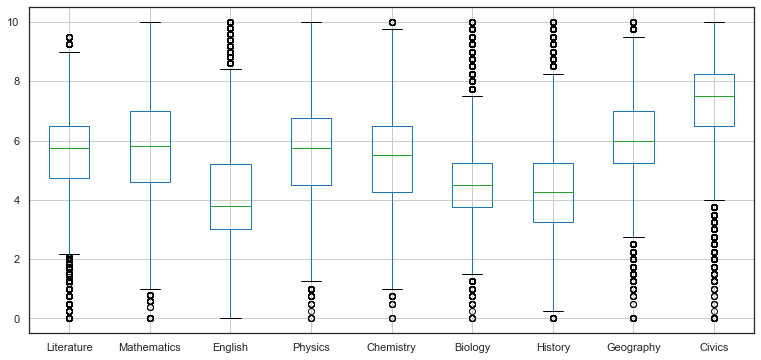

In [264]:
data.boxplot(figsize=(13,6));

Now the data will be split into the two subgroups. First take a look a the distribution of the null values.

In [207]:
data.notnull().value_counts(normalize=True).head()

Literature  Mathematics  English  Physics  Chemistry  Biology  History  Geography  Civics
True        True         True     False    False      False    True     True       True      0.609875
                                  True     True       True     False    False      False     0.348832
                                                               True     True       True      0.036439
                                  False    False      False    False    False      False     0.002870
                                                               True     True       False     0.001088
dtype: float64

By just inspecting the the first see rows that about 61% of the students choose all subjects in the social sciences group(History, Geography, Civics) and no subject of the natural sciences, 35% choose all of the natural sciences and nothing of the social science group, and 4% all subjects of both groups. All other combinations have only a minor proportion.

In [208]:
data_nat = data.drop(columns=['History','Geography','Civics'])
data_soc = data.drop(columns=['Physics','Chemistry','Biology'])
data_nat.dropna(inplace=True)
data_soc.dropna(inplace=True)

Look at statistical summary of the two groups.

First the natural science group.

In [209]:
data_nat.describe()

,Literature,Mathematics,English,Physics,Chemistry,Biology
count,278835.000000,278835.000000,278835.000000,278835.000000,278835.000000,278835.000000
mean,5.648728,6.871080,4.754569,5.614784,5.379063,4.672791
std,1.081378,1.303663,1.772183,1.582223,1.562123,1.220652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,6.200000,3.400000,4.500000,4.250000,3.750000
50%,5.750000,7.000000,4.400000,5.750000,5.500000,4.500000
75%,6.500000,7.800000,5.800000,6.750000,6.500000,5.250000
max,9.500000,10.000000,10.000000,10.000000,10.000000,10.000000


Now the social science group.

In [210]:
data_soc.describe()

,Literature,Mathematics,English,History,Geography,Civics
count,467543.000000,467543.000000,467543.000000,467543.000000,467543.000000,467543.000000
mean,5.501327,5.054904,3.888643,4.360118,6.082849,7.353743
std,1.358061,1.504843,1.630299,1.418792,1.184020,1.268342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.750000,4.000000,2.800000,3.250000,5.250000,6.500000
50%,5.500000,5.000000,3.400000,4.250000,6.000000,7.500000
75%,6.500000,6.200000,4.600000,5.250000,7.000000,8.250000
max,9.500000,9.800000,10.000000,10.000000,10.000000,10.000000


Create boxplots for each group.

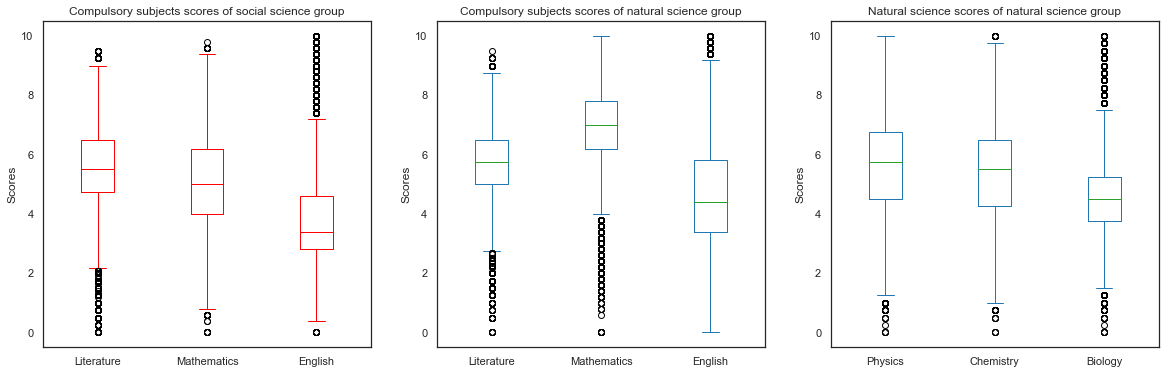

In [222]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
data_soc[['Literature','Mathematics','English']].plot(kind='box', color='red',
                                                       figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Compulsory subjects scores of social science group')
ax0.set_ylabel('Scores')

# Subplot 2: Line plot
data_nat[['Literature','Mathematics','English']].plot(kind='box', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Compulsory subjects scores of natural science group')
ax1.set_ylabel('Scores')


data_nat[['Physics','Chemistry','Biology']].plot(kind='box', figsize=(20, 6), ax=ax2) # add to subplot 2
ax2.set_title ('Natural science scores of natural science group')
ax2.set_ylabel('Scores')


plt.show()

Comparing the distributions, one can see that in the natural science group the math scores are significantly higher, and the English scores slightly higher, while the literature scores are similarly distributed. Also, the Physics and Chemistry scores are similarly distributed, while the Biology scores are lower with low variance.

In the following only the natural science group will be further analyzed.

Take a look at the correlations.

In [213]:
# The correlation matrix
corr_mat = data_nat.corr()

# Strip out the diagonal values for the next step
for x in range(data_nat.shape[1]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Literature,Mathematics,English,Physics,Chemistry,Biology
Literature,0.000000,0.296153,0.286556,0.209559,0.225634,0.247895
Mathematics,0.296153,0.000000,0.447106,0.655566,0.591430,0.358286
English,0.286556,0.447106,0.000000,0.392942,0.192394,0.251817
Physics,0.209559,0.655566,0.392942,0.000000,0.501041,0.185336
Chemistry,0.225634,0.591430,0.192394,0.501041,0.000000,0.436126
Biology,0.247895,0.358286,0.251817,0.185336,0.436126,0.000000


In [214]:
# Pairwise maximal correlations
corr_mat.abs().idxmax()

Literature     Mathematics
Mathematics        Physics
English        Mathematics
Physics        Mathematics
Chemistry      Mathematics
Biology          Chemistry
dtype: object

One can see that all feautures are except biology are mostly corrolated with math. Furthermore, of the natural sciences physics is most corrolated with math, while biology is least corrolated with math.

Now look at the skewness of each feature. 

In [215]:
skew_columns = (data_nat.skew().sort_values(ascending=False))

skew_columns

English        0.644075
Biology        0.562476
Chemistry     -0.173754
Physics       -0.263909
Literature    -0.308892
Mathematics   -0.777838
dtype: float64

The absolute skewness value for all features is less than 1, meaning no feature column is highly skewed. So is not absolutely necessary to reduce the skewness of any feature. 

# Clustering Analysis

Now, a clustering analysis of the natural science group will be conducted using kmeans. The goal is to find the optimal number of clusters, while still having room for interpretion, i.e. being able to characterize these clusters.

Luckily, all features are on the same scale of 0-10. So no feature scaling is needed.

Try k-means for 2-10 clusters. In case elbow method does not yield clear solution, also compute the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

In [216]:
# Create and fit a range of models
km_list = list()

for clust in range(2,11):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data_nat)
    score = silhouette_score(data_nat,km.labels_,sample_size=25000,random_state=42)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km,
                              'silhouette': score}))

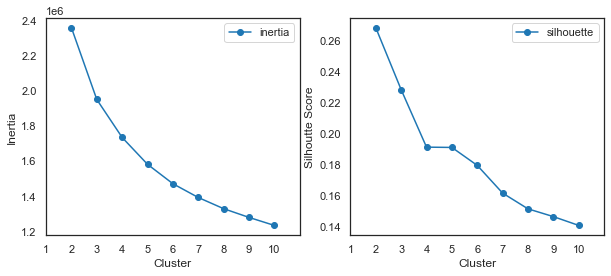

In [217]:
fig = plt.figure() 

ax1 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax2 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**


plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-',ax=ax1,figsize=(10,4))
ax.set_xticks(range(1,11,1))
ax.set_xlim(1,11)
ax.set(xlabel='Cluster', ylabel='Inertia');


plot_data2 = (pd.concat(km_list, axis=1)
             .T
             [['clusters','silhouette']]
             .set_index('clusters'))

ax = plot_data2.plot(marker='o',ls='-',ax=ax2,figsize=(10,4))
ax.set_xticks(range(1,11,1))
ax.set_xlim(1,11)
ax.set(xlabel='Cluster', ylabel='Silhoutte Score');


plt.show()

After looking at the inertia plot one can see there is no clear elbow point. However, with 5 clusters the decrease rate of the inertia seems to begin slowing down. Looking at the silhoutte score plot one can see that it until 4 it drastically decreases and then the decrease rate begins to slow down, but the score at 4 and 5 are about the same.<br> So choose 5 as the number of clusters.

In [218]:
km = KMeans(n_clusters=5, random_state=42)
km = km.fit(data_nat)

data_nat['kmeans'] = km.predict(data_nat)

,Literature,Mathematics,English,Physics,Chemistry,Biology,total_average
kmeans,,,,,,,
4,6.191758,7.650636,5.499910,5.488739,6.963314,6.680389,6.412458
3,6.055814,7.666347,7.522270,6.679343,5.191092,4.725929,6.306799
2,5.676614,7.703681,4.285751,7.002171,6.726233,4.581311,5.995960
1,5.594440,6.469090,4.017289,5.088853,4.882950,4.450792,5.083902
0,4.816460,4.867224,3.190841,3.379921,3.314844,3.675972,3.874210


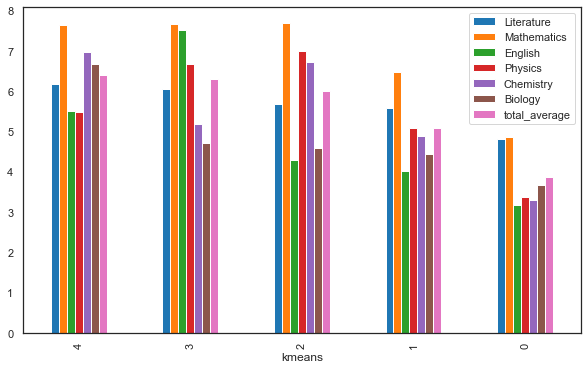

In [262]:
clusters = data_nat.groupby(by='kmeans').mean()
clusters['total_average'] = clusters.sum(axis=1)/6

clusters.sort_values(by='total_average',ascending=False,inplace=True)
clusters.rename(index={0:4,2:3,1:2,4:1,3:0},inplace=True)

clusters.plot.bar(figsize=(10,6)).legend(bbox_to_anchor=(1.0,1));
clusters

After looking at the mean scores, one see that there is a "low group" consisting of one group(class=0), where the scores are the lowest accross all subjects, and one "middle group" consisting also of one group(class=1), where the scores in the middle accross all subjects. There is one "top group" consisting of one three subgroups. They have all similar math scores. One group(class 2) is has low scores in English, but high scores in Physics and Chemistry. Another group(class 3) has high scores in English and Physics, but low scores in Chemistry and Biology. Finally, the last top group(class4) has middle scores in English, low scores in Physics, but high scores in Chemistry and Biology.

Finally, conduct Principal Component Analysis(PCA) and see whether the dimension can be reduced without losing too much variance 
explainability.

In [220]:
pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

columns = [x for x in data_nat.columns if x not in ['kmeans']]


for n in range(1, 6):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data_nat[columns])
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features':data_nat[columns].columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.494612
2,PCA(n_components=2),0.686415
3,PCA(n_components=3),0.811869
4,PCA(n_components=4),0.889425
5,PCA(n_components=5),0.953435


As a result, dimension can be reduced to one dimension less without losing more than 5 percent of the variance.

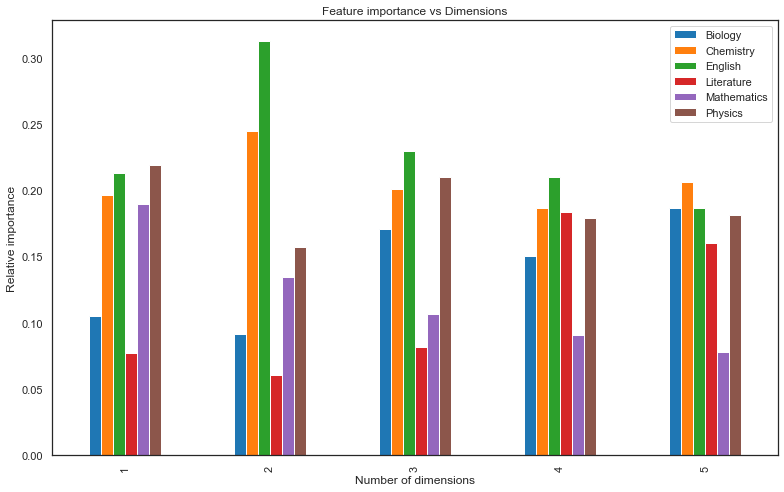

In [221]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

ax = features_df.plot(kind='bar', figsize=(13,8))
ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');


One can see that the feature importance of English, Physics and Chemistry is higher compared to the other features along all dimensions.

## Conclusion

By means of kmeans with 5 clusters a good clustering has been achieved. Other clustering algorithms have been omitted, because they need two much time and memory taking into account the large size of the dataset. It would be interesting to see how the clusters  would look like if one would apply other algorithms with optimized hyperparameters, there the number of clusters is not given a priori.<br>
This is a very nice dataset, but unfortunately contains only the scores and no extra information, like the sex of the participants or  the region they come from.